## Data Source
1. http://medicaldecathlon.com/
2. Licience: https://creativecommons.org/licenses/by-sa/4.0/

In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm

#### Path to Images and Label

In [2]:
images = Path('../datasets/Atrium-Segmentation/imagesTr/')
labels = Path('../datasets/Atrium-Segmentation/labelsTr/')
images,labels

(WindowsPath('../datasets/Atrium-Segmentation/imagesTr'),
 WindowsPath('../datasets/Atrium-Segmentation/labelsTr'))

#### Celluliod: Easy Matplotlib Animation
<font color='red'>Extracting a sample image segmentation task</font>

In [3]:
sample_data_path = images / 'la_029.nii.gz'
sample_label_path = labels / 'la_029.nii.gz'
sample_data_path,sample_label_path

(WindowsPath('../datasets/Atrium-Segmentation/imagesTr/la_029.nii.gz'),
 WindowsPath('../datasets/Atrium-Segmentation/labelsTr/la_029.nii.gz'))

In [4]:
sample_data = nib.load(sample_data_path)
sample_label = nib.load(sample_label_path)

scanning_direction = nib.aff2axcodes(sample_data.affine) # Know how images are taken
# R A S
MRI_DATA = tf.cast(sample_data.get_fdata(),dtype=np.float16)
MASK = tf.cast(sample_label.get_fdata(),dtype=np.int8)

In [5]:
MRI_DATA.shape,MASK.shape

(TensorShape([320, 320, 109]), TensorShape([320, 320, 109]))

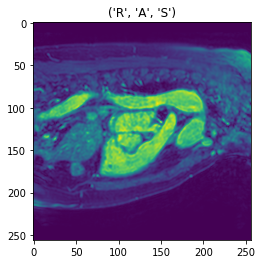

In [6]:
plt.title(f'{scanning_direction}')
plt.imshow(MRI_DATA[32:-32,32:-32,50])

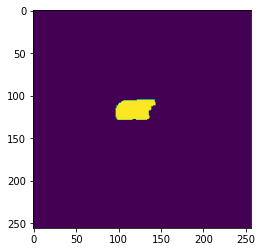

In [7]:
plt.imshow(MASK[32:-32,32:-32,50])

## Saving images and label maps into TFRecord

In [12]:
all_image_files = list(images.glob('la*'))
all_label_files = list(labels.glob('la*'))
len(all_image_files),len(all_label_files)

(20, 20)

In [13]:
save_root = '../datasets/Atrium-Segmentation/TF-Record/'
save_root

'../datasets/Atrium-Segmentation/TF-Record/'

In [14]:
# TF Record
def image_feature(image):
#     # Must be 3-dimensional
    img = tf.io.encode_png(image).numpy()
    img = tf.train.Feature(
            bytes_list = tf.train.BytesList(value=[img],)
    )
    return img


def create_example(image,segment):
    feature = {
        'image':image_feature(image),
        'seg_map':image_feature(segment)
    }
    record = tf.train.Example(features=tf.train.Features(feature=feature))
    return record

## Training Set

In [15]:
for idx, data in enumerate(zip(all_image_files,all_label_files)):
    print(f"Working on file {idx+1} / 20",end='\r')
    
    image_path = nib.load(data[0])
    mri = image_path.get_fdata()
    
    label_path = nib.load(data[1])
    seg = label_path.get_fdata()
    
    # Extract Data using nibabel
    mri = mri[32:-32,32:-32,:]
    mri = tf.cast(mri,dtype = tf.uint16)
    
    seg = seg[32:-32,32:-32,:]
    seg = tf.cast(seg,dtype= tf.uint8) 
    
    if idx <=15:
        with tf.io.TFRecordWriter(save_root + f'train_{idx}.tfrec') as writer:

            for slice_num in range(mri.shape[-1]):
                # Extract image slices
                mri_slice = mri[:,:,slice_num]
                seg_slice = seg[:,:,slice_num]

        
                # reshape to (256,256,1)
                mri_slice = tf.reshape(mri_slice,shape = list(mri_slice.shape) + [1])
                seg_slice = tf.reshape(seg_slice,shape = list(seg_slice.shape) + [1])

                tf_record = create_example(mri_slice,seg_slice)
                writer.write(tf_record.SerializeToString())
                
    # Else
    else:
        with tf.io.TFRecordWriter(save_root + f'test_{idx}.tfrec') as writer:
            
            for slice_num in range(mri.shape[-1]):
                # Extract image slices
                mri_slice = mri[:,:,slice_num]
                seg_slice = seg[:,:,slice_num]

                # reshape to (256,256,1)
                mri_slice = tf.reshape(mri_slice,shape = list(mri_slice.shape) + [1])
                seg_slice = tf.reshape(seg_slice,shape = list(seg_slice.shape) + [1])

                tf_record = create_example(mri_slice,seg_slice)
                writer.write(tf_record.SerializeToString())
                            
        

        
    
